⚠️  XGBoost not available. Install with: pip install xgboost

               WEATHER PREDICTION SYSTEM

📁 Loading historical data...
✓ Loaded 366 rows from weather.csv
✓ After cleaning: 366 rows
🔧 Engineering features...

TRAINING RAIN PREDICTION MODELS
  RandomForest        : 82.43%
  LogisticRegression  : 90.54%
  SVM                 : 82.43%

✓ Best model: LogisticRegression (90.54%)

Classification Report:
              precision    recall  f1-score   support

     No Rain       0.92      0.97      0.94        61
        Rain       0.80      0.62      0.70        13

    accuracy                           0.91        74
   macro avg       0.86      0.79      0.82        74
weighted avg       0.90      0.91      0.90        74


TRAINING REGRESSION MODELS


/tmp/ipykernel_23234/3721758761.py:114: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_23234/3721758761.py:121: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

  Temperature RMSE: 0.40°C
  Humidity RMSE: 0.29%

📊 Generating visualizations...
⚠️  Feature importance not available for this model type

🔍 Fetching current weather for Tashkent...

                    WEATHER REPORT FOR Tashkent, UZ

📍 CURRENT CONDITIONS:
   Temperature: 14.0°C (feels like 12.3°C)
   Range: 14.0°C - 14.0°C
   Humidity: 35%
   Pressure: 1025 hPa
   Wind: NW at 2.06 m/s
   Conditions: smoke

🌧️  RAIN PREDICTION (using LogisticRegression):
   Tomorrow: No ☀️
   Confidence: 0.1% rain, 99.9% no rain

📊 5-HOUR FORECAST:
   Time     Temp (°C)    Humidity (%)
   -------- ------------ ------------
   17:00    13.8         35.5        
   18:00    14.2         33.2        
   19:00    14.2         33.5        
   20:00    15.1         35.3        
   21:00    14.7         35.6        

⚠️  NOTE: Predictions based on limited historical data.
   For production, use multi-year data with hourly granularity.



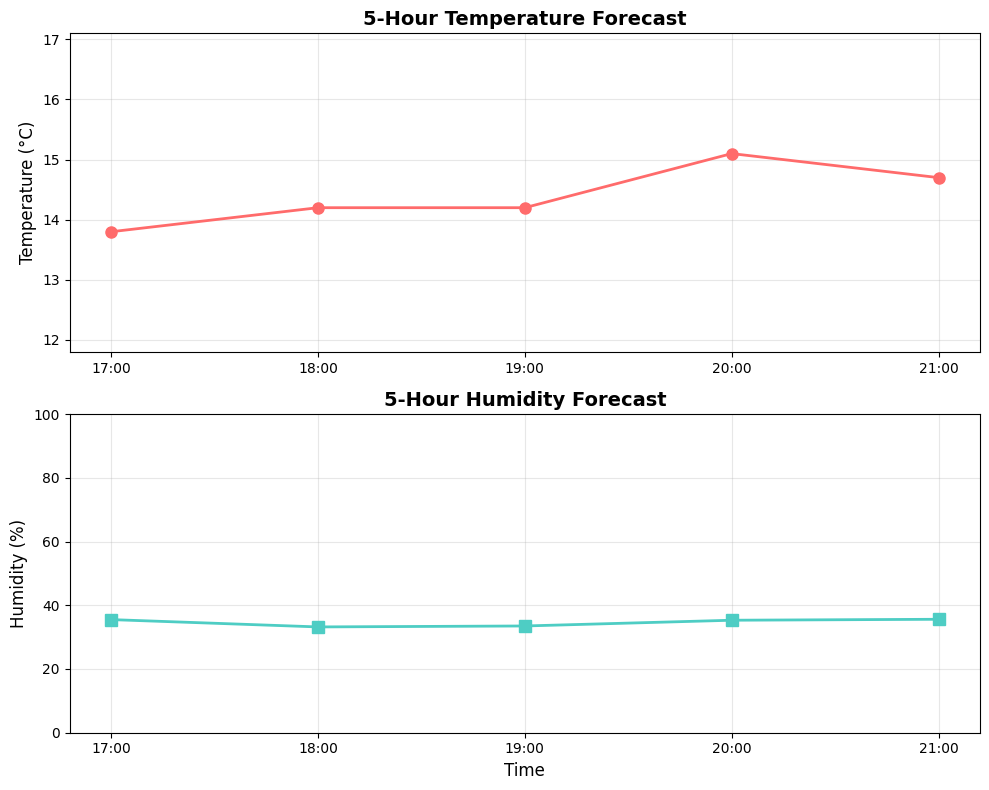

In [12]:
"""
Enhanced Weather Prediction System
Combines API integration + advanced ML + visualizations
"""

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report

# Try XGBoost (optional)
try:
    from xgboost import XGBClassifier, XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False
    print("⚠️  XGBoost not available. Install with: pip install xgboost")

# ============================================================================
# CONFIGURATION
# ============================================================================
API_KEY = '0ea12166dca6efaa2a7077602c59e70d'
BASE_URL = 'https://api.openweathermap.org/data/2.5/'
DATA_PATH = 'weather.csv'

DIRECTION_MAP = {
    'N': 0, 'NNE': 1, 'NE': 2, 'ENE': 3, 'E': 4, 'ESE': 5,
    'SE': 6, 'SSE': 7, 'S': 8, 'SSW': 9, 'SW': 10, 'WSW': 11,
    'W': 12, 'WNW': 13, 'NW': 14, 'NNW': 15, 'NA': 16
}

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def deg_to_compass(deg):
    """Convert degrees to compass direction"""
    if pd.isna(deg):
        return 'NA'
    try:
        deg = float(deg) % 360
    except:
        return str(deg) if str(deg) in DIRECTION_MAP else 'NA'
    
    compass_points = [
        ("N", 0, 11.25), ("NNE", 11.25, 33.75), ("NE", 33.75, 56.25),
        ("ENE", 56.25, 78.75), ("E", 78.75, 101.25), ("ESE", 101.25, 123.75),
        ("SE", 123.75, 146.25), ("SSE", 146.25, 168.75), ("S", 168.75, 191.25),
        ("SSW", 191.25, 213.75), ("SW", 213.75, 236.25), ("WSW", 236.25, 258.75),
        ("W", 258.75, 281.25), ("WNW", 281.25, 303.75), ("NW", 303.75, 326.25),
        ("NNW", 326.25, 348.75), ("N", 348.75, 360)
    ]
    
    for direction, start, end in compass_points:
        if start <= deg < end:
            return direction
    return 'N'

def get_current_weather(city):
    """Fetch current weather from OpenWeatherMap API"""
    try:
        url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        return {
            'city': data['name'],
            'country': data['sys']['country'],
            'current_temp': round(data['main']['temp'], 1),
            'feels_like': round(data['main']['feels_like'], 1),
            'temp_min': round(data['main']['temp_min'], 1),
            'temp_max': round(data['main']['temp_max'], 1),
            'humidity': round(data['main']['humidity']),
            'description': data['weather'][0]['description'],
            'wind_deg': data['wind'].get('deg', 0),
            'pressure': data['main']['pressure'],
            'wind_speed': data['wind'].get('speed', 0)
        }
    except requests.exceptions.RequestException as e:
        print(f"❌ Error fetching weather data: {e}")
        return None
    except KeyError as e:
        print(f"❌ Unexpected API response format: {e}")
        return None

# ============================================================================
# DATA PROCESSING
# ============================================================================

def load_and_clean_data(filepath):
    """Load and clean historical weather data"""
    try:
        df = pd.read_csv(filepath)
        print(f"✓ Loaded {len(df)} rows from {filepath}")
    except FileNotFoundError:
        raise FileNotFoundError(f"❌ {filepath} not found!")
    
    # Drop all-NaN rows
    df = df.dropna(how='all')
    
    # Fill numeric columns with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isna().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    
    # Fill categorical with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df[col].isna().sum() > 0:
            mode_val = df[col].mode()
            df[col].fillna(mode_val.iloc[0] if len(mode_val) > 0 else 'NA', inplace=True)
    
    # Drop duplicates
    df = df.drop_duplicates()
    
    print(f"✓ After cleaning: {len(df)} rows")
    return df

def engineer_features(df):
    """Add derived features"""
    df = df.copy()
    
    # Temperature range
    if 'MinTemp' in df.columns and 'MaxTemp' in df.columns:
        df['TempRange'] = df['MaxTemp'] - df['MinTemp']
    else:
        df['TempRange'] = 0
    
    # Wind-Pressure ratio
    if 'WindGustSpeed' in df.columns and 'Pressure' in df.columns:
        df['WindPressureRatio'] = df['WindGustSpeed'] / df['Pressure'].replace(0, np.nan).fillna(df['Pressure'].median())
    else:
        df['WindPressureRatio'] = 0
    
    # Humidity level (categorical)
    if 'Humidity' in df.columns:
        df['HumidityLevel'] = pd.cut(df['Humidity'], bins=[-1, 40, 70, 100], labels=[0, 1, 2]).astype(int)
    else:
        df['HumidityLevel'] = 1
    
    # Feels like approximation
    if 'Temp' in df.columns and 'Humidity' in df.columns:
        df['FeelsLikeCalc'] = df['Temp'] + (df['Humidity'] * 0.01 * df['Temp'] * 0.1)
    else:
        df['FeelsLikeCalc'] = df.get('Temp', 0)
    
    # Encode wind direction
    if 'WindGustDir' in df.columns:
        # Check if numeric (degrees) or string (compass)
        sample = str(df['WindGustDir'].dropna().iloc[0]) if len(df['WindGustDir'].dropna()) > 0 else ''
        
        if sample.replace('.', '', 1).replace('-', '', 1).isdigit():
            # Convert degrees to compass
            df['WindGustDirCompass'] = df['WindGustDir'].apply(deg_to_compass)
        else:
            # Already compass direction
            df['WindGustDirCompass'] = df['WindGustDir'].astype(str).str.upper()
        
        df['WindGustDir_Encoded'] = df['WindGustDirCompass'].map(DIRECTION_MAP).fillna(16).astype(int)
    else:
        df['WindGustDir_Encoded'] = 16
    
    return df

def prepare_classification_data(df):
    """Prepare features and target for rain prediction"""
    # Target variable
    if 'RainTomorrow' not in df.columns:
        raise ValueError("❌ 'RainTomorrow' column required!")
    
    y = (df['RainTomorrow'].astype(str).str.strip().str.upper() == 'YES').astype(int)
    
    # Feature columns
    feature_cols = []
    for col in ['MinTemp', 'MaxTemp', 'Temp', 'TempRange', 'FeelsLikeCalc',
                'Humidity', 'HumidityLevel', 'Pressure', 'WindGustSpeed',
                'WindGustDir_Encoded', 'WindPressureRatio']:
        if col in df.columns:
            feature_cols.append(col)
    
    X = df[feature_cols].fillna(0)
    
    return X, y, feature_cols

def prepare_regression_data(df):
    """Prepare data for temperature/humidity regression"""
    reg_features = []
    for col in ['MinTemp', 'MaxTemp', 'Humidity', 'Pressure', 'WindGustSpeed',
                'TempRange', 'FeelsLikeCalc', 'WindPressureRatio', 'WindGustDir_Encoded']:
        if col in df.columns:
            reg_features.append(col)
    
    X = df[reg_features].fillna(0).values
    
    y_temp = df['Temp'].values if 'Temp' in df.columns else None
    y_hum = df['Humidity'].values if 'Humidity' in df.columns else None
    
    return X, y_temp, y_hum, reg_features

# ============================================================================
# MODEL TRAINING
# ============================================================================

def train_rain_models(X, y):
    """Train multiple classification models and return the best"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=120, random_state=42),
        'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
        'SVM': SVC(probability=True, random_state=42)
    }
    
    if xgb_available:
        models['XGBoost'] = XGBClassifier(random_state=42, eval_metric='logloss')
    
    results = {}
    print("\n" + "="*50)
    print("TRAINING RAIN PREDICTION MODELS")
    print("="*50)
    
    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            results[name] = acc
            print(f"  {name:20s}: {acc:.2%}")
        except Exception as e:
            print(f"  {name:20s}: Error - {e}")
    
    # Select best model
    best_name = max(results, key=results.get)
    best_model = models[best_name]
    
    print(f"\n✓ Best model: {best_name} ({results[best_name]:.2%})")
    
    # Show classification report for best model
    preds = best_model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, preds, target_names=['No Rain', 'Rain']))
    
    return best_model, best_name, X_test, y_test

def train_regression_models(X, y_temp, y_hum):
    """Train regression models for temperature and humidity"""
    print("\n" + "="*50)
    print("TRAINING REGRESSION MODELS")
    print("="*50)
    
    # Temperature model
    if y_temp is not None:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_temp, test_size=0.2, random_state=42
        )
        temp_model = RandomForestRegressor(n_estimators=120, random_state=42)
        temp_model.fit(X_train, y_train)
        
        preds = temp_model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        print(f"  Temperature RMSE: {rmse:.2f}°C")
    else:
        temp_model = None
        print("  Temperature: Skipped (no data)")
    
    # Humidity model
    if y_hum is not None:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_hum, test_size=0.2, random_state=42
        )
        hum_model = RandomForestRegressor(n_estimators=120, random_state=42)
        hum_model.fit(X_train, y_train)
        
        preds = hum_model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        print(f"  Humidity RMSE: {rmse:.2f}%")
    else:
        hum_model = None
        print("  Humidity: Skipped (no data)")
    
    return temp_model, hum_model

# ============================================================================
# PREDICTION & FORECASTING
# ============================================================================

def predict_rain(model, current_weather, feature_cols, direction_map):
    """Predict rain probability from current weather"""
    compass_dir = deg_to_compass(current_weather['wind_deg'])
    wind_encoded = direction_map.get(compass_dir, 16)
    
    # Build feature vector
    features = {
        'MinTemp': current_weather['temp_min'],
        'MaxTemp': current_weather['temp_max'],
        'Temp': current_weather['current_temp'],
        'TempRange': current_weather['temp_max'] - current_weather['temp_min'],
        'FeelsLikeCalc': current_weather['feels_like'],
        'Humidity': current_weather['humidity'],
        'HumidityLevel': 0 if current_weather['humidity'] < 40 else (1 if current_weather['humidity'] < 70 else 2),
        'Pressure': current_weather['pressure'],
        'WindGustSpeed': current_weather['wind_speed'],
        'WindGustDir_Encoded': wind_encoded,
        'WindPressureRatio': current_weather['wind_speed'] / current_weather['pressure']
    }
    
    # Create DataFrame with only features used in training
    X_current = pd.DataFrame([[features.get(col, 0) for col in feature_cols]], columns=feature_cols)
    
    prediction = model.predict(X_current)[0]
    
    try:
        probabilities = model.predict_proba(X_current)[0]
    except:
        probabilities = [1-prediction, prediction]
    
    return prediction, probabilities

def forecast_future(temp_model, hum_model, current_weather, historical_df, reg_features, hours=5):
    """Forecast temperature and humidity for next N hours"""
    predictions = []
    
    last_temp = current_weather['current_temp']
    last_hum = current_weather['humidity']
    
    # Calculate trends from historical data
    temp_trend = historical_df['Temp'].tail(50).mean() if 'Temp' in historical_df.columns else last_temp
    hum_trend = historical_df['Humidity'].tail(50).mean() if 'Humidity' in historical_df.columns else last_hum
    
    for h in range(hours):
        # Build feature vector
        features_dict = {
            'MinTemp': last_temp - 1,
            'MaxTemp': last_temp + 1,
            'Humidity': last_hum,
            'Pressure': current_weather['pressure'],
            'WindGustSpeed': current_weather['wind_speed'],
            'TempRange': 2,
            'FeelsLikeCalc': last_temp + 0.01 * last_hum * last_temp * 0.1,
            'WindPressureRatio': current_weather['wind_speed'] / current_weather['pressure'],
            'WindGustDir_Encoded': DIRECTION_MAP.get(deg_to_compass(current_weather['wind_deg']), 16)
        }
        
        features = np.array([[features_dict.get(col, 0) for col in reg_features]])
        
        # Predict next values
        if temp_model:
            next_temp = float(temp_model.predict(features)[0])
            # Add trend and small noise
            trend_component = 0.05 * (temp_trend - last_temp)
            noise = np.random.normal(0, 0.3)
            next_temp = np.clip(next_temp + trend_component + noise, -50, 60)
        else:
            next_temp = last_temp
        
        if hum_model:
            next_hum = float(hum_model.predict(features)[0])
            trend_component = 0.03 * (hum_trend - last_hum)
            noise = np.random.normal(0, 1)
            next_hum = np.clip(next_hum + trend_component + noise, 0, 100)
        else:
            next_hum = last_hum
        
        predictions.append({
            'temp': round(next_temp, 1),
            'humidity': round(next_hum, 1)
        })
        
        last_temp = next_temp
        last_hum = next_hum
    
    return predictions

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_feature_importance(model, feature_names):
    """Plot feature importance for tree-based models"""
    try:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importance for Rain Prediction')
        plt.barh(range(len(indices)), importances[indices])
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
    except AttributeError:
        print("⚠️  Feature importance not available for this model type")

def plot_forecast(forecast, timezone_str='Asia/Tashkent'):
    """Plot temperature and humidity forecast"""
    temps = [p['temp'] for p in forecast]
    hums = [p['humidity'] for p in forecast]
    
    # Generate time labels
    tz = pytz.timezone(timezone_str)
    now = datetime.now(tz)
    next_hour = (now + timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
    times = [(next_hour + timedelta(hours=i)).strftime("%H:00") for i in range(len(forecast))]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Temperature
    ax1.plot(times, temps, marker='o', linewidth=2, markersize=8, color='#ff6b6b')
    ax1.set_title('5-Hour Temperature Forecast', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Temperature (°C)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(min(temps) - 2, max(temps) + 2)
    
    # Humidity
    ax2.plot(times, hums, marker='s', linewidth=2, markersize=8, color='#4ecdc4')
    ax2.set_title('5-Hour Humidity Forecast', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Humidity (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN FUNCTION
# ============================================================================

def main():
    """Main execution function"""
    print("\n" + "="*70)
    print(" "*15 + "WEATHER PREDICTION SYSTEM")
    print("="*70)
    
    # Load and process data
    print("\n📁 Loading historical data...")
    df = load_and_clean_data(DATA_PATH)
    
    print("🔧 Engineering features...")
    df = engineer_features(df)
    
    # Prepare data
    X_class, y_class, feature_cols = prepare_classification_data(df)
    X_reg, y_temp, y_hum, reg_features = prepare_regression_data(df)
    
    # Train models
    rain_model, model_name, X_test, y_test = train_rain_models(X_class, y_class)
    temp_model, hum_model = train_regression_models(X_reg, y_temp, y_hum)
    
    # Show feature importance
    print("\n📊 Generating visualizations...")
    plot_feature_importance(rain_model, feature_cols)
    
    # Get current weather
    city = input("\n🌍 Enter city name (or press Enter for Tashkent): ").strip() or "Tashkent"
    
    print(f"\n🔍 Fetching current weather for {city}...")
    current = get_current_weather(city)
    
    if not current:
        print("❌ Could not fetch weather data. Exiting.")
        return
    
    # Predict rain
    rain_pred, rain_prob = predict_rain(rain_model, current, feature_cols, DIRECTION_MAP)
    
    # Forecast future
    forecast = forecast_future(temp_model, hum_model, current, df, reg_features)
    
    # Display results
    print("\n" + "="*70)
    print(f" "*20 + f"WEATHER REPORT FOR {current['city']}, {current['country']}")
    print("="*70)
    
    print(f"\n📍 CURRENT CONDITIONS:")
    print(f"   Temperature: {current['current_temp']}°C (feels like {current['feels_like']}°C)")
    print(f"   Range: {current['temp_min']}°C - {current['temp_max']}°C")
    print(f"   Humidity: {current['humidity']}%")
    print(f"   Pressure: {current['pressure']} hPa")
    print(f"   Wind: {deg_to_compass(current['wind_deg'])} at {current['wind_speed']} m/s")
    print(f"   Conditions: {current['description']}")
    
    print(f"\n🌧️  RAIN PREDICTION (using {model_name}):")
    print(f"   Tomorrow: {'Yes ☔' if rain_pred else 'No ☀️'}")
    print(f"   Confidence: {rain_prob[1]:.1%} rain, {rain_prob[0]:.1%} no rain")
    
    print(f"\n📊 5-HOUR FORECAST:")
    print(f"   {'Time':<8} {'Temp (°C)':<12} {'Humidity (%)':<12}")
    print(f"   {'-'*8} {'-'*12} {'-'*12}")
    
    tz = pytz.timezone('Asia/Tashkent')
    now = datetime.now(tz)
    next_hour = (now + timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
    
    for i, pred in enumerate(forecast):
        time_str = (next_hour + timedelta(hours=i)).strftime("%H:00")
        print(f"   {time_str:<8} {pred['temp']:<12.1f} {pred['humidity']:<12.1f}")
    
    print("\n" + "="*70)
    print("⚠️  NOTE: Predictions based on limited historical data.")
    print("   For production, use multi-year data with hourly granularity.")
    print("="*70 + "\n")
    
    # Plot forecast
    plot_forecast(forecast)

if __name__ == "__main__":
    main()